# Capstone Project - The Battle of the Neighborhoods (Week 2)

## Applied Data Science Capstone by IBM/Coursera

# Table of Contents

<ul>
    <li name="Introduction">Introduction</li>
    <li><a>Data Collection from APIs</a></li>
    <li><a>Data Cleaning</a></li>
    <li><a>Methodolgy</a></li>
    <li><a>Analysis</a></li>
    <li><a>Results and Discussion</a></li>
    <li><a>Conclusion</a></li>
    
</ul>

# Introduction

The aim of the project is to identify venues in varanasi, India based on their rating and average prices. In this notebook, we will identify various venues in the city of varanasi, India, using Foursquare API and Zomato API, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

# Data

To begin with, we will take a look at varanasi on the Map using the folium library.

We will also fetch the data from two different APIs.

### Foursquare API : 
We will use the Foursquare API to fetch venues in varanasi starting from the middle upto 6 Kilometers in each direction.
### Zomato API: 
The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

Varanasi is a city in the northern Indian state of Uttar Pradesh dating to the 11th century B.C. Regarded as the spiritual capital of India, the city draws Hindu pilgrims who bathe in the Ganges River’s sacred waters and perform funeral rites. Along the city's winding streets are some 2,000 temples, including Kashi Vishwanath, the “Golden Temple,” dedicated to the Hindu god Shiva.

> We can use the geopy library to extract the latitude and longitude values of Varanasi but it seems off and thus, we'll directly supply the values in this case.

In [9]:
VRS_LATITUDE = 25.3176
VRS_LONGITUDE = 82.9739
print('The geograpical coordinates of Varanasi are {}, {}.'.format(VRS_LATITUDE, VRS_LONGITUDE))

The geograpical coordinates of Varanasi are 25.3176, 82.9739.


Let's use the folium library to create a complete map zoomed on varanasi. We'll also plot a marker on the coordinates we just identified above. This would give us a relatively good look at the center point we will be considering

In [10]:
import folium
varanasi_map = folium.Map(location = [VRS_LATITUDE, VRS_LONGITUDE], zoom_start = 13)
folium.Marker([VRS_LATITUDE, VRS_LONGITUDE]).add_to(varanasi_map)
varanasi_map

## Foursquare API
We begin by fetching a total of all venues in varanasi upto a range of 6 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [11]:
FOURSQUARE_CLIENT_ID = 'GMUUC2GUMFOORGUE1X1RP5TDHGBFHG05QV0RBE5G3DIWIMVG'
FOURSQUARE_CLIENT_SECRET = 'AKKTWEFY02L5UQCS0P2KKNHOLPQQT1AZWPQMIWSO0AMJ2EI0'
RADIUS = 6000 # 4 Km
NO_OF_VENUES = 100
VERSION = '20190612' # Current date


We define the get_category_type method to get the correct category for each venue.

In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 41, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        VRS_LATITUDE, 
                                                                        VRS_LONGITUDE,
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 45 venues fetched within a total radius of 6.0 Km

Total 45 venues fetched


## Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

In [14]:
headers = {'user-key': 'b3a1c26ed20422bfaae7ada558744e1f'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [15]:
zomato_venues

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Hotel Dolphin International,25.2995300290,82.9995642040,500.0,3.0,3.8,"B 20/48, Near Jain Mandir, Bhelupur, Varanasi"
1,Punjab Grill House,25.3094922309,83.0045169219,300.0,2.0,2.9,"Near Church Crossing, Luxa Road, Godaulia, Var..."
2,Kashi Chat Bhandar,25.3093913007,83.0059475452,150.0,1.0,4.7,"D-37/49, Godaulia, Varanasi"
3,Dawat,25.3096328663,83.0053490773,1200.0,4.0,3.0,"Hotel Ganges Grand, Godowlia Crossing, Godauli..."
4,UBQ by Barbeque Nation,25.3356311000,82.9776407000,400.0,2.0,3.1,"JHV Mall, 4th, The Mall Rd, Near Ramada Hotel,..."
5,0,0,0,0.0,0.0,0,None
6,Dolphin Restaurant,25.3078649107,83.0099621415,700.0,3.0,3.7,"D 16/30 Manmandir Ghat, Dashwamedh Road, Varanasi"
7,The Siwon Lassi Shop,25.3114830000,83.0111220000,100.0,1.0,3.6,"Tripura Bhairwi Road, Nepali Kapda, Dashaswmed..."
8,Sushi Cafe & Continental Restaurant,25.3053200000,83.0084490000,400.0,2.0,3.4,"D-32, 13-14, Bangali Tola Road, Bangali Tola, ..."
9,Sol Bar - Hotel Surya,25.3387057134,82.9798902199,1500.0,4.0,3.6,"Hotel Surya, 20/51, A-5, The Mall Road, Varuna..."


# Data Cleaning

The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

### We will first plot the Foursquare data on the map.

In [16]:
varanasi_map = folium.Map(location = [VRS_LATITUDE, VRS_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(varanasi_map)  

#chandigarh_map.save("maps/Venues by Foursquare.html")
varanasi_map

## We will also plot the Zomato data on the map.

In [17]:
VRS_LATITUDE = 25.3176
VRS_LONGITUDE = 82.9739
varanasi_map = folium.Map(location = [VRS_LATITUDE, VRS_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [float(latitude),float(longitude)],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(varanasi_map)  
varanasi_map

### Combining the dataset

To combine the two datasets, I'll have to check that the latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values upto 4 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [18]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [19]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [20]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Stops Hostel Varanasi,Hostel,25.2995,82.9997,Hotel Dolphin International,25.2995,82.9996,500.0,3.0,3.8,"B 20/48, Near Jain Mandir, Bhelupur, Varanasi",0.0000,-0.0001
1,Kashi Chat Bhandar,Indian Restaurant,25.3095,83.0061,Kashi Chat Bhandar,25.3094,83.0059,150.0,1.0,4.7,"D-37/49, Godaulia, Varanasi",-0.0001,-0.0002
2,JHV Mall,Shopping Mall,25.3357,82.9777,UBQ by Barbeque Nation,25.3356,82.9776,400.0,2.0,3.1,"JHV Mall, 4th, The Mall Rd, Near Ramada Hotel,...",-0.0001,-0.0001
3,Hotel Surya,Hotel,25.3388,82.9800,Sol Bar - Hotel Surya,25.3387,82.9799,1500.0,4.0,3.6,"Hotel Surya, 20/51, A-5, The Mall Road, Varuna...",-0.0001,-0.0001
4,Pizzeria Vaatika Café,Pizza Place,25.2894,83.0062,Pizzeria Vaatika Cafe,25.2894,83.0061,700.0,3.0,4.2,B 1/178 Assi Varanasi,0.0000,-0.0001
5,Assi Ghat,Temple,25.2888,83.0062,Taste Of Banaras,25.2885,83.0060,300.0,2.0,0,"Assi Ghat, Shivala, Varanasi",-0.0003,-0.0002
6,Ashish Cafe,Café,25.2897,83.0060,Pizzeria Vaatika Cafe,25.2894,83.0061,700.0,3.0,4.2,B 1/178 Assi Varanasi,-0.0003,0.0001
7,Open Hand Café & Shop,Coffee Shop,25.2880,83.0045,Open Hand Shop & Cafe,25.2880,83.0045,450.0,2.0,4.2,"B1/128-3, Dumraun Bagh Colony, Assi Ghat, Vara...",0.0000,0.0000
8,Domino's Pizza,Pizza Place,25.3160,82.9860,Domino's Pizza,25.3161,82.9856,400.0,2.0,3.9,"14, Ground Floor, Cinema Site, IP Mallvaranasi...",0.0001,-0.0004
9,Kerala Cafe,Indian Restaurant,25.3000,83.0012,The Belgian Waffle Co,25.2997,83.0011,300.0,2.0,4.2,"Beside Kerala Cafe, Bhelupura Chauraha\nVaranasi",-0.0003,-0.0001


In [21]:
selected_venues = selected_venues.drop([0, 2, 5, 6, 9,11,13,14,15,16]).reset_index(drop = True)

In [22]:
selected_venues.head()

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Kashi Chat Bhandar,Indian Restaurant,25.3095,83.0061,Kashi Chat Bhandar,25.3094,83.0059,150.0,1.0,4.7,"D-37/49, Godaulia, Varanasi",-0.0001,-0.0002
1,Hotel Surya,Hotel,25.3388,82.9800,Sol Bar - Hotel Surya,25.3387,82.9799,1500.0,4.0,3.6,"Hotel Surya, 20/51, A-5, The Mall Road, Varuna...",-0.0001,-0.0001
2,Pizzeria Vaatika Café,Pizza Place,25.2894,83.0062,Pizzeria Vaatika Cafe,25.2894,83.0061,700.0,3.0,4.2,B 1/178 Assi Varanasi,0.0000,-0.0001
3,Open Hand Café & Shop,Coffee Shop,25.2880,83.0045,Open Hand Shop & Cafe,25.2880,83.0045,450.0,2.0,4.2,"B1/128-3, Dumraun Bagh Colony, Assi Ghat, Vara...",0.0000,0.0000
4,Domino's Pizza,Pizza Place,25.3160,82.9860,Domino's Pizza,25.3161,82.9856,400.0,2.0,3.9,"14, Ground Floor, Cinema Site, IP Mallvaranasi...",0.0001,-0.0004


we'll now select the venue name from Zomato API. I'll also get the average price per person by dividing the column price_for_two by 2 and removing this column from the dataset along with other unnecessary columns.

In [23]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

Let's take a look at the final dataset that is left with us.

In [24]:

selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Indian Restaurant,Kashi Chat Bhandar,25.3094,83.0059,1.0,4.7,"D-37/49, Godaulia, Varanasi",75.0
1,Hotel,Sol Bar - Hotel Surya,25.3387,82.9799,4.0,3.6,"Hotel Surya, 20/51, A-5, The Mall Road, Varuna...",750.0
2,Pizza Place,Pizzeria Vaatika Cafe,25.2894,83.0061,3.0,4.2,B 1/178 Assi Varanasi,350.0
3,Coffee Shop,Open Hand Shop & Cafe,25.2880,83.0045,2.0,4.2,"B1/128-3, Dumraun Bagh Colony, Assi Ghat, Vara...",225.0
4,Pizza Place,Domino's Pizza,25.3161,82.9856,2.0,3.9,"14, Ground Floor, Cinema Site, IP Mallvaranasi...",200.0


I'll drop the venues which have 0.0 rating as it means it's not been rated yet.

In [25]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 7


# Methodology

This project aims at identifying the venues in varanasi based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information from the center of varanasi, upto a distance of 6 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

# Analysis

The complete dataset is now in its final form.

We will inspect these venues based on their rating. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

## Categories

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 5 artists>

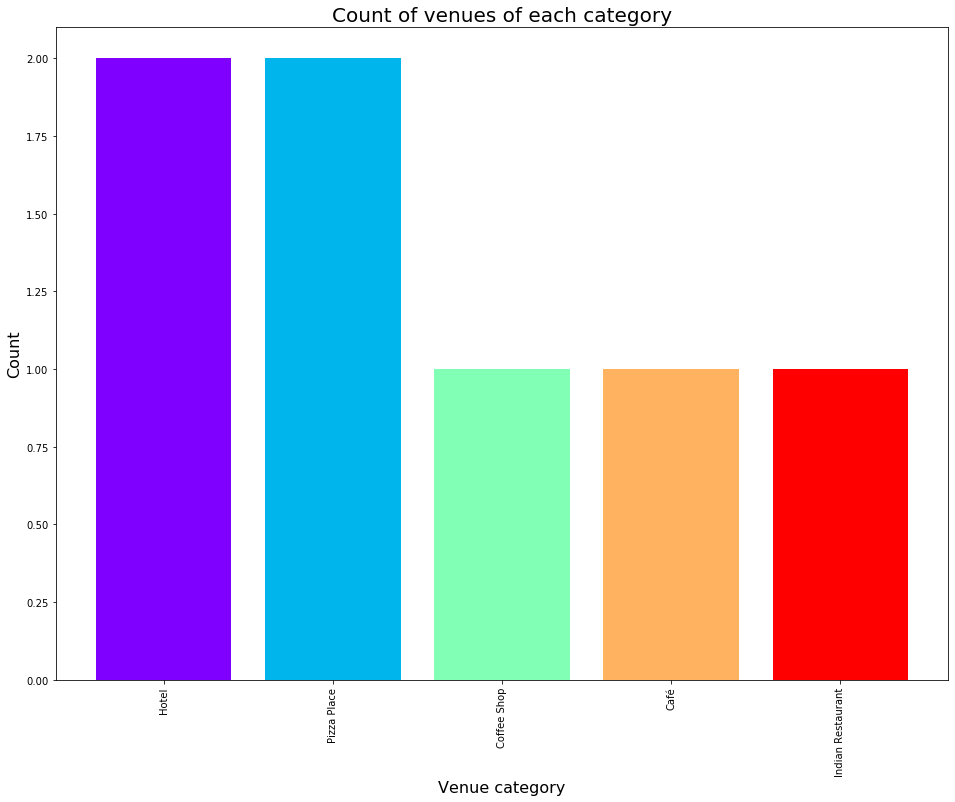

In [26]:

venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (16, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 20)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are Hotel and Pizza Places. So, if as a tourist, you're looking for Hotel and Pizza Places, you're in luck.


## Rating

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

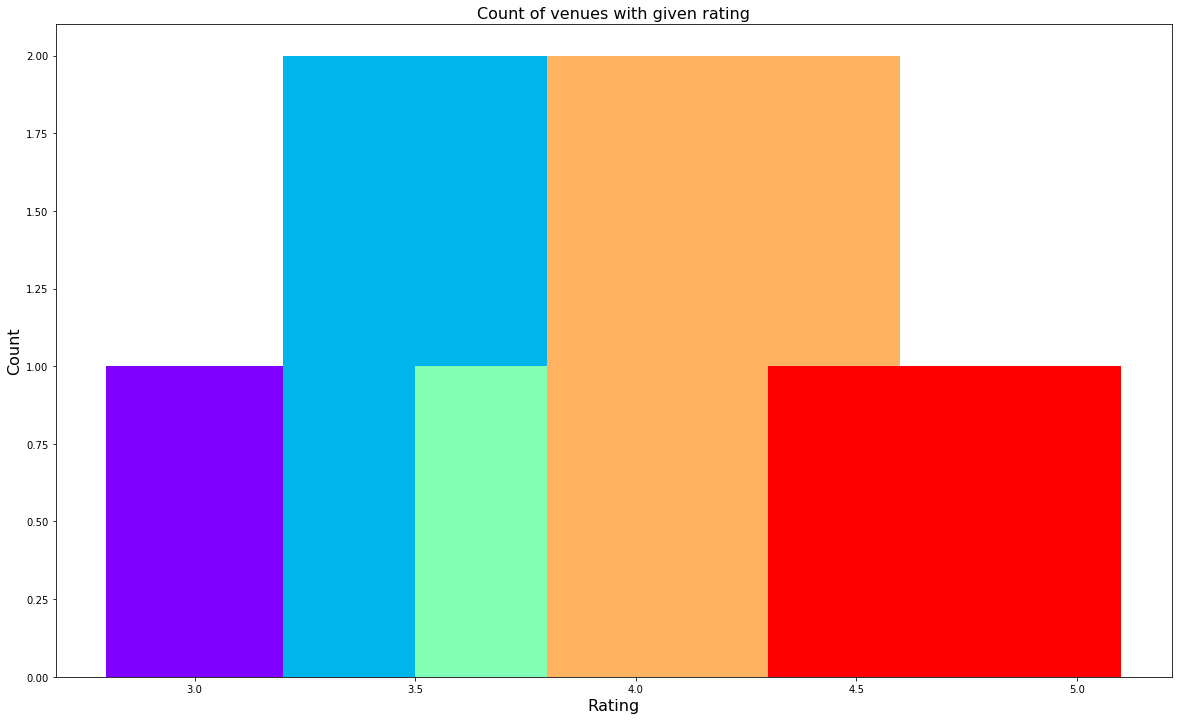

In [27]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that majority venues have their rating close to 3.5 and 4.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

>1 to 2 

>2 to 3

>3 to 4

>4 to 5

In [28]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Now, we will plot the venues on the map.

In [29]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

varanasi_map = folium.Map(location = [VRS_LATITUDE, VRS_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(varanasi_map)  
varanasi_map

>Users might also be interested in going to a place that fits in their budget. I'll use the price_range column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [30]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

varanasi_map = folium.Map(location = [VRS_LATITUDE, VRS_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(varanasi_map)  
varanasi_map

> As shown in map "Ocean - The Rivatas, Rivatas, The Mall Road, Cantonment, Nadesar, Varanasi" is very costly.

> As shown in map "Kashi Chat Bhandar, D-37/49, Godaulia, Varanasi" is least expensive.


## Clustering
We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [31]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Indian Restaurant,Kashi Chat Bhandar,25.3094,83.0059,1.0,4.7,"D-37/49, Godaulia, Varanasi",75.0,Very good
1,1,Hotel,Sol Bar - Hotel Surya,25.3387,82.9799,4.0,3.6,"Hotel Surya, 20/51, A-5, The Mall Road, Varuna...",750.0,Good
2,0,Pizza Place,Pizzeria Vaatika Cafe,25.2894,83.0061,3.0,4.2,B 1/178 Assi Varanasi,350.0,Very good
3,0,Coffee Shop,Open Hand Shop & Cafe,25.2880,83.0045,2.0,4.2,"B1/128-3, Dumraun Bagh Colony, Assi Ghat, Vara...",225.0,Very good
4,0,Pizza Place,Domino's Pizza,25.3161,82.9856,2.0,3.9,"14, Ground Floor, Cinema Site, IP Mallvaranasi...",200.0,Good
5,1,Hotel,Ocean - The Rivatas,25.3376,82.9796,4.0,3.6,"Rivatas, The Mall Road, Cantonment, Nadesar, V...",900.0,Good
6,0,Café,Brown Bread Bakery,25.3032,83.0075,3.0,3.2,"D 25/42 Ganga Mahal, Bangali Tola, Pandey Ghat...",250.0,Good


In [32]:
varanasi_map = folium.Map(location = [VRS_LATITUDE, VRS_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [float(latitude), float(longitude)],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(varanasi_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [float(latitude), float(longitude)],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(varanasi_map)

varanasi_map

> Here is 2 clusters on is in Red colour.

> Other Clusters in Green Colour.

I'll also check the venues of the two clusters.

In [33]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Indian Restaurant,Kashi Chat Bhandar,25.3094,83.0059,1.0,4.7,"D-37/49, Godaulia, Varanasi",75.0,Very good
1,0,Pizza Place,Pizzeria Vaatika Cafe,25.2894,83.0061,3.0,4.2,B 1/178 Assi Varanasi,350.0,Very good
2,0,Coffee Shop,Open Hand Shop & Cafe,25.2880,83.0045,2.0,4.2,"B1/128-3, Dumraun Bagh Colony, Assi Ghat, Vara...",225.0,Very good
3,0,Pizza Place,Domino's Pizza,25.3161,82.9856,2.0,3.9,"14, Ground Floor, Cinema Site, IP Mallvaranasi...",200.0,Good
4,0,Café,Brown Bread Bakery,25.3032,83.0075,3.0,3.2,"D 25/42 Ganga Mahal, Bangali Tola, Pandey Ghat...",250.0,Good


In [34]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 2.20 and rating spread around 4.04


## Clusters 2

In [35]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Hotel,Sol Bar - Hotel Surya,25.3387,82.9799,4.0,3.6,"Hotel Surya, 20/51, A-5, The Mall Road, Varuna...",750.0,Good
1,1,Hotel,Ocean - The Rivatas,25.3376,82.9796,4.0,3.6,"Rivatas, The Mall Road, Cantonment, Nadesar, V...",900.0,Good


In [36]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 4.00 and rating spread around 3.60


## Result and Discussion

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of varanasi, India.



After collecting data from the Foursquare and Zomato APIs, we got a list of 41 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 16.

We identified that from the total set of venues, majority of them were Hotel and Pizza Places.

Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of 3.57. On the other hand, there are few venues which are high priced and have average rating of 4.0.

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

# Conclusion

The purpose of this project was to explore the places that a person visiting to varanasi . The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are so many places where one can visit during his stay in varanasi. Based on the visitor's venue rating and price requirements, he/she can choose the places.